<a href="https://colab.research.google.com/github/wahyudesu/Gelar-rasa-2023/blob/main/demo_sms_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo SMS Spam Detection

## Preparing resources

In [ ]:
!pip install transformers datasets
## WARNING: Reload google colab runtime after run this
!pip install accelerate -U

### Download SMS Spam Bahasa Indonesia Dataset

Provided by Yudi Wibisono

[Other dataset can be access here](https://github.com/kmkurn/id-nlp-resource)

In [ ]:
!gdown --id 1-stKadfTgJLtYsHWqXhGO3nTjKVFxm_Q
!unzip -o /content/dataset_sms_spam_bhs_indonesia_v1.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-stKadfTgJLtYsHWqXhGO3nTjKVFxm_Q
To: /content/dataset_sms_spam_bhs_indonesia_v1.zip
100% 52.8k/52.8k [00:00<00:00, 71.7MB/s]
Archive:  /content/dataset_sms_spam_bhs_indonesia_v1.zip
  inflating: dataset_sms_spam_v1.csv  
  inflating: penjelasan.txt          


### Exploring dataset

In [ ]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("dataset_sms_spam_v1.csv")
display_dataset = dataset.copy()

In [ ]:
display_dataset.head(10)

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2
5,5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket ...,2
6,"Ada iRing dgn tarif Rp. 0,1/7hr (perpanjangan ...",2
7,Akhir bulan harus tetap eksis loh! Internetan ...,2
8,Aktifkan iRing Coboy Jr - Terhebat. Tekan *808...,2
9,Ambil bonus harianmu di *600# (Bebas Pulsa). D...,2


In [ ]:
display_dataset.loc[display_dataset.label == 0, 'label'] = 'NORMAL'
display_dataset.loc[display_dataset.label == 1, 'label'] = 'FRAUD'
display_dataset.loc[display_dataset.label == 2, 'label'] = 'PROMO'

In [ ]:
display_dataset.head(100)

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,PROMO
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,PROMO
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",PROMO
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",PROMO
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,PROMO
...,...,...
95,Isi ulang Rp50000.0 berhasil. Kode transaksi 9...,PROMO
96,Jalani ibadah Haji dg nyaman tnpa prlu ganti k...,PROMO
97,"Jangan dikejar diskon berlari, beli RAWIT disk...",PROMO
98,JANGAN LUPA kirim 50 SMS sd 16 Juni 2013 utk m...,PROMO


<Axes: >

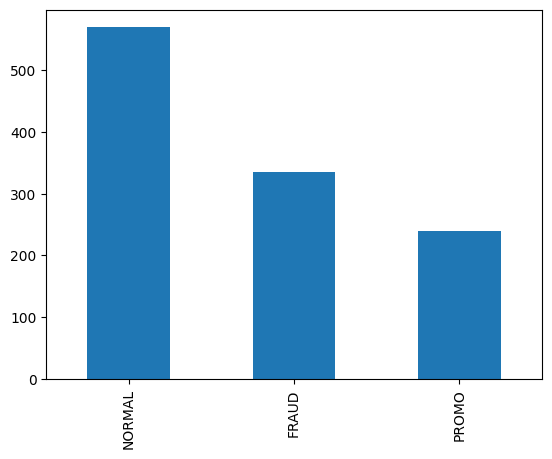

In [ ]:
_labels = display_dataset['label'].value_counts()
_labels.plot.bar()

### Split dataset into train, validation, and test split

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(dataset.Teks.to_list(), dataset.label.to_list(), shuffle=True, test_size=.2)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts, val_labels, test_size=.5)

### Tokenize texts

In [ ]:
import torch
from torch import nn
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
train_encodings = tokenizer(train_texts, return_tensors="pt", truncation=True, padding=True, )
val_encodings = tokenizer(val_texts, return_tensors="pt", truncation=True, padding=True)
test_encodings = tokenizer(test_texts, return_tensors="pt", truncation=True, padding=True)

In [ ]:
class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
val_dataset = SpamDataset(val_encodings, val_labels)
test_dataset = SpamDataset(test_encodings, test_labels)

In [ ]:
from typing import Dict
from sklearn.metrics import precision_recall_fscore_support
from transformers import EvalPrediction
def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids.flatten(), preds.flatten(), average='weighted', zero_division=0)
    return {
        'accuracy': (preds == p.label_ids).mean(),
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Get pretrained model and train it

In [ ]:
from torch.utils.data import DataLoader
from transformers import XLMRobertaForSequenceClassification, XLMRobertaConfig, AdamW, TrainingArguments, Trainer

config = XLMRobertaConfig.from_pretrained(
    'xlm-roberta-base',
    num_labels=3
)
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', config=config)
seed = 13

training_args = TrainingArguments(
    do_train=True,
    output_dir='./results',          # output directory
    num_train_epochs=10,             # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # output log every #
    seed=seed,                       # random seed
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-25f667961a90>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,1.159600
20,1.164200
30,1.163700
40,1.122700
50,1.056100
60,1.017600
70,0.940400
80,0.854000
90,0.763800
100,0.604000


<ipython-input-10-25f667961a90>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=580, training_loss=0.27663650611768764, metrics={'train_runtime': 278.001, 'train_samples_per_second': 32.878, 'train_steps_per_second': 2.086, 'total_flos': 629396073235440.0, 'train_loss': 0.27663650611768764, 'epoch': 10.0})

## Evaluations

In [ ]:
# Evaluations
results = {}
result = trainer.evaluate()
for key, value in result.items():
  print("{} = {}".format(key, value))

<ipython-input-10-25f667961a90>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


eval_loss = 0.42471787333488464
eval_accuracy = 0.9385964912280702
eval_f1 = 0.93946286414137
eval_precision = 0.9418036885142148
eval_recall = 0.9385964912280702
eval_runtime = 0.625
eval_samples_per_second = 182.415
eval_steps_per_second = 3.2
epoch = 10.0


## Test the model

In [ ]:
labels = ['NORMAL', 'FRAUD', 'PROMO']
is_spam = [
           'Kepoin suster Anya Geraldine di original series terbaru World of Dr. Boyke dg kode voucher BIMA dr Vidio utk km pelanggan Tri. Dptkan akses Vidio Premier Platinum 30 Hari dr 49rb, skrg hny 20rb! Cek di http://bimaplus.tri.co.id/Vidio',
           'PAKET SPESIAL YG LANGKA! Kuota 3GB 3hr Cuma Rp10rb. Balas HO untuk aktifkan. Nikmati kuota 1.5GB+1.5GB(01-09). AS203',
           'SHOPEE Slmt. NO.+6287878xxx Anda Resmi Men-daptkan Hadiah Ke-2 Cek Tunai Rp.175jt Kode ID Pemenang ;(AD25MD47) U/Info Hadiah Klik. www.super-shoppingday-99.com',
           'Selamat! SIM CARD Anda terpilih menjadi pemenang dari pesta ISI ULANG MOBOINDOSAT. Pin JK25FGR untuk info silakan kunjungi: www.juaramobo.cf',
           'Jaga jarak, hindari kerumunan. Aspirasi adalah hak, namunn tak lupa protokol kesehatan. #LindungiDiri #LindungiKeluarga covid19.go.id',
           'Apakah ini spam?',
           'Hanya kk&ktp sudah bisa buat modal usaha dengan bunga 0,2% Min 5-500jt Melayani Seluruh Indonesia Minat WA:081996947567',
           'fitria ,Minggu kmarin ketemu kaamu dijalan, kaamu sdh tidak kenal aku, coba lIhat fotoku chat-v.com/s/9dtu8y',
           'Sebagai nasabah Yth rek anda diNyatakan resmi mendpt hadiah dari berkah BRIpoin & Kode Cek Anda 02591234 Utk INFO klik:http://berkahpoinbri.blogspot.com',
           'Mmber bru ekstra didepan 300% sampai 2jta (tox7) hny dg 25K Klaim id dpt bnus harian smpai 5% http://ga4c0orabis.lol'
]
encoded = tokenizer(is_spam,truncation=True, padding=True, return_tensors="pt")
encoded.to('cuda')
output = model(encoded['input_ids'], attention_mask=encoded['attention_mask'])
output_cpu = output[0].cpu()
output_indices = output_cpu.max(1).indices.tolist()

In [ ]:
for index in range(len(is_spam)):
  print(is_spam[index])
  print('Result = {}'.format(labels[output_indices[index]]))
  print('-'*20)


Kepoin suster Anya Geraldine di original series terbaru World of Dr. Boyke dg kode voucher BIMA dr Vidio utk km pelanggan Tri. Dptkan akses Vidio Premier Platinum 30 Hari dr 49rb, skrg hny 20rb! Cek di http://bimaplus.tri.co.id/Vidio
Result = PROMO
--------------------
PAKET SPESIAL YG LANGKA! Kuota 3GB 3hr Cuma Rp10rb. Balas HO untuk aktifkan. Nikmati kuota 1.5GB+1.5GB(01-09). AS203
Result = PROMO
--------------------
SHOPEE Slmt. NO.+6287878xxx Anda Resmi Men-daptkan Hadiah Ke-2 Cek Tunai Rp.175jt Kode ID Pemenang ;(AD25MD47) U/Info Hadiah Klik. www.super-shoppingday-99.com
Result = FRAUD
--------------------
Selamat! SIM CARD Anda terpilih menjadi pemenang dari pesta ISI ULANG MOBOINDOSAT. Pin JK25FGR untuk info silakan kunjungi: www.juaramobo.cf
Result = FRAUD
--------------------
Jaga jarak, hindari kerumunan. Aspirasi adalah hak, namunn tak lupa protokol kesehatan. #LindungiDiri #LindungiKeluarga covid19.go.id
Result = NORMAL
--------------------
Apakah ini spam?
Result = NORMAL


In [ ]:
tokenizer.tokenize(is_spam[1])

['▁PA',
 'KET',
 '▁SP',
 'ESI',
 'AL',
 '▁',
 'YG',
 '▁L',
 'ANGKA',
 '!',
 '▁Ku',
 'ota',
 '▁3',
 'GB',
 '▁3',
 'hr',
 '▁Cuma',
 '▁Rp',
 '10',
 'rb',
 '.',
 '▁Bala',
 's',
 '▁HO',
 '▁untuk',
 '▁aktif',
 'kan',
 '.',
 '▁Nik',
 'mati',
 '▁ku',
 'ota',
 '▁1.5',
 'GB',
 '+',
 '1.5',
 'GB',
 '(',
 '01',
 '-',
 '09)',
 '.',
 '▁AS',
 '203']